In [57]:
## Sarsa Algorithm on Cliff Walking

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [58]:
## Cliff Walking Environment, including a target and a start, reward = -1 normally, reward = -100 if falling off. 


class CliffWalkingEnv:
    def __init__(self, nrow, ncol):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0 # Agent x cor
        self.y = self.nrow - 1 # Agent y cor
        
    # Agent's action
    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # action: down, up, left, right
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0])) # determine whether x is out of bound
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1])) # determine whether y is out of bound
        
        reward = -1
        next_state = self.y * self.ncol + self.x
        
        done = False
        
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            
            if self.x != self.ncol - 1: ## Fall into the lake
                reward = -100
                
        return next_state, reward, done
    
    def reset(self):
        
        self.x = 0
        self.y = nrow - 1
        
        return self.y * self.ncol + self.x

In [59]:
# Agent using sarsa algorithm 

# Sarsa = TD(0)/TD(lambda) in policy evaluation + epsilon-greedy policy improvement

class Sarsa:
    def __init__(self, ncol, nrow, alpha, gamma, epsilon, n_action = 4): 
        
        # gamma is the decline for future reward, alpha is an degree estimation of reward update
        
        self.Q_table = np.zeros([nrow * ncol, n_action]) # Discrete Q-table for states
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    
    def take_action(self, state): # epsilon-Greedy algorithm, there is chance epsilon we explore by taking random actions
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
            
        return action
    
    # For printing actions
    
    def best_action(self, state):
        Q_max = np.argmax(self.Q_table[state])
        a = [0 for i in range(self.n_action)]
        
        for j in range(self.n_action):
            if self.Q_table[state, j] == Q_max:
                a[j] = 1
        
        return a
    
    #Temporal Difference (TD(0)) algorithm on updating Q-value
      
    def update(self, s0, a0, r, s1, a1): # s0 current state, a0 current action, s1 next state, a1 next action
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += td_error * alpha

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 7496.52it/s, episode=500, return=-12.900]


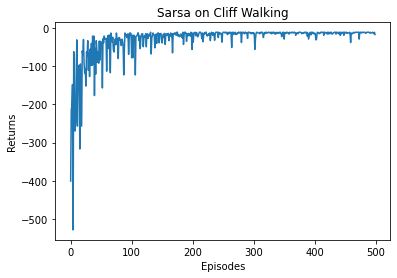

In [60]:
# Experiment

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.15
gamma = 0.9
agent = Sarsa(ncol, nrow, alpha, gamma, epsilon)

num_episodes = 500

return_list = [] 


for i in range(10):  
    #tqdm
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            
            done = False
            
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                
                episode_return += reward  
                
                agent.update(state, action, reward, next_state, next_action)
                
                state = next_state
                action = next_action
                
            return_list.append(episode_return)
            
            if (i_episode + 1) % 10 == 0:  
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [61]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo oooo oooo oooo 
oooo **** **** **** 
**** **** **** **** 
**** **** **** EEEE 


In [62]:
# N-step Sarsa Algorithm

class nstep_Sarsa():
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.n = n # step number
        self.state_list = [] # maintain a state list for n step
        self.action_list = [] # maintain an action list for n step
        self.reward_list = [] # maintain a reward list for n step
        
    def take_action(self, state): # epsilon-Greedy algorithm, there is chance epsilon we explore by taking random actions
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
            
        return action
    
    def best_action(self, state): 
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    
    #Temporal Difference (TD(n)) algorithm on updating Q-value
      
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G += self.gamma * G + self.reward_list[i]
                
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
                
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)

            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4876.64it/s, episode=500, return=-13.200]


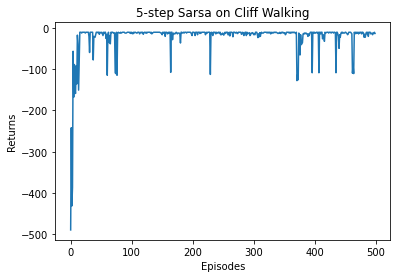

In [63]:
np.random.seed(0)
n_step = 5
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 

return_list = []  

for i in range(10):  
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [64]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5步Sarsa算法最终收敛得到的策略为：
ooo> ^ooo ^ooo ovoo 
oo<o oo<o ovoo ovoo 
^ooo ooo> ovoo ovoo 
ovoo ovoo ooo> ovoo 
ovoo ooo> ovoo ovoo 
ovoo ovoo ovoo ovoo 
ooo> ovoo ovoo ovoo 
ooo> ovoo ooo> ovoo 
ooo> ovoo ooo> ovoo 
ooo> **** **** **** 
**** **** **** **** 
**** **** **** EEEE 
